In [1]:
#NOTE about this version - 
#(1) All implementations are vectorized and have been checked against original implementation.
#(2) eps is added to all spectrograms to get rid of divide by zero error.
#(3) Dividing by freq_bin is removed in the SH implementation - not specified in original paper.
#(4) No NaN problems so the pandas notnull function has been removed everywhere
#(5) Calling acoustic indices functions from a separate .ipynb file - AcousticInd - note: importing numpy, defining eps in each
#(6) Loads data from .npy files
#(7) Adding a parameter to normalize all data 

#Has operations to get different scatterplots as functions named exp1_... and so on.

#This program loads data from 4 different classes
#good, bad, human, maybe

#And uses 5 different acoustic indices on num_spec recordings from each
#1. ACI 2. ADI 3. ADI_even 4. SH 5. NDSI

#Each recording is exactly 2 s long

#Final result: a scatter plot for each acoustic index + scatterplot matrix - pandas

#Spectrograms used: original+4 differential channels


In [2]:
#imports
import numpy as np
from matplotlib import pyplot as plt
from scipy.signal import hilbert
from scipy.signal import stft
import librosa
import os

#for scatter matrix
import pandas as pd
from pandas.plotting import scatter_matrix

#setting eps value for converting spec to log
eps = 1e-10

#function definitions for acoustic indices begin here


In [3]:
#imports for Acoustic indices functions
from ipynb.fs.full.AcousticInd import compute_aci
from ipynb.fs.full.AcousticInd import compute_adi
from ipynb.fs.full.AcousticInd import get_start_stop_indices
from ipynb.fs.full.AcousticInd import compute_adi_even
from ipynb.fs.full.AcousticInd import compute_sh
from ipynb.fs.full.AcousticInd import compute_ndsi

In [4]:
#function to load spectrograms and display dimensions (optional)
def load_display_dimensions(class_name, str_file, dim=0):

    #   description of data files
    #   spec_data is like a dict with fields
    #   'specs' (contains the mel-filtered spectrograms, in linear scale, as [num_specs, num_rows, num_cols])
    #   'spec_f' (contains the frequency axis points as a 1D array)
    #   'spec_t' (contains the time axis points as a 1D array)   
    
    fname_load = class_name + str_file
    spec_data = np.load(fname_load)
    
    time_steps = len(spec_data['spec_t'])
    freq_bins = len(spec_data['spec_f'])
    
    if (dim==1):
        print('File has %i specs of dimensions (%i x %i)' % (
        spec_data['specs'].shape[0], spec_data['specs'].shape[1], spec_data['specs'].shape[2]))
        print('Frequency axis points are in spec_data[\'spec_f\'] and has %i values' % freq_bins)
        print('Time axis points are in spec_data[\'spec_t\'] and has %i values' % time_steps)
        
    return spec_data, time_steps, freq_bins
    


In [5]:
#function to calculate all acoustic indices and plot spectrogram (optional)
def calc_plot(num_bins, spec_start_idx, num_specs, spec_data, ch, time_steps, freq_bins, freq_vals, start_freq_idx, stop_freq_idx, start_a_freq, stop_a_freq, start_b_freq, stop_b_freq, plot=0):
    
    ACI = np.zeros((num_specs, 1))
    ADI = np.zeros((num_specs, 1))
    ADI_even = np.zeros((num_specs, 1))
    SH = np.zeros((num_specs, 1))
    NDSI = np.zeros((num_specs, 1))
       
    if (plot==1):
        fig, axes = plt.subplots(num_specs, 1, sharex='all')
        plt.title('Spectrogram for ' + 'good')
      
    #Store log version of all spectrograms in all_specs
    #all_specs = 10 * np.log10(spec_data['specs'][spec_start_idx:spec_start_idx+num_specs, :, :] + eps)
    
    if(ch==-1):
        #Original spectrogram
        all_specs = 10 * np.log10(spec_data['specs'][spec_start_idx:spec_start_idx+num_specs, :, :] + eps)
    elif (ch==5):
        #Experiment no. 4 - has 3 dimensions only
        all_specs = spec_data
    else:
        #4 differential channels so 1 dimension extra at the end for which channel
        all_specs = spec_data['specs'][spec_start_idx:spec_start_idx+num_specs, :, :, ch] 

    #Vectorized implementations 
    ACI = compute_aci(all_specs, time_steps, freq_bins, num_specs)
    ADI = compute_adi(all_specs, time_steps)
    ADI_even = compute_adi_even(num_bins, all_specs, freq_vals, start_freq_idx, stop_freq_idx)
    SH = compute_sh(all_specs, time_steps, freq_bins)
    NDSI = compute_ndsi(all_specs, start_freq_idx, stop_freq_idx, start_a_freq, stop_a_freq, start_b_freq, stop_b_freq)
             
    if(plot==1):
        cax = axes[spec_idx].imshow(current_spec, cmap=plt.get_cmap('jet'), interpolation='none', origin='lower')
        fig.colorbar(cax, ax=axes[spec_idx], orientation='vertical')
        
    
    return ACI, ADI, ADI_even, SH, NDSI


In [6]:
#calls all functions for each class - is for the original data
def calls_orig(class_name, spec_start_idx, num_specs, multiples, num_bins, dim, start_a_freq, stop_a_freq, start_b_freq, stop_b_freq, plot=0):

    #Load the correct file
    str_file = '.npz'
    spec_data, time_steps, freq_bins = load_display_dimensions(class_name, str_file, dim)
    
    #Calling helper function for compute_adi_even
    start_freq_idx, stop_freq_idx = get_start_stop_indices(spec_data['spec_f'], multiples, num_bins)

    #Computing acoustic indices for all 4 channels
    ch = -1
    ACI, ADI, ADI_even, SH, NDSI = calc_plot(num_bins, spec_start_idx, num_specs, spec_data, ch, time_steps, freq_bins, spec_data['spec_f'], start_freq_idx, stop_freq_idx, start_a_freq, stop_a_freq, start_b_freq, stop_b_freq, plot)
    
    return ACI, ADI, ADI_even, SH, NDSI

In [7]:
#calls all functions for each class
def calls(class_name, spec_start_idx, num_specs, multiples, num_bins, dim, start_a_freq, stop_a_freq, start_b_freq, stop_b_freq, plot=0):

    #Load the correct file
    str_file = '_preprocessed_uncompressed.npz'
    spec_data, time_steps, freq_bins = load_display_dimensions(class_name, str_file, dim)
    
    #Calling helper function for compute_adi_even
    start_freq_idx, stop_freq_idx = get_start_stop_indices(spec_data['spec_f'], multiples, num_bins)

    #Computing acoustic indices for all 4 channels
    ACI1, ADI1, ADI_even1, SH1, NDSI1 = calc_plot(num_bins, spec_start_idx, num_specs, spec_data, 0, time_steps, freq_bins, spec_data['spec_f'], start_freq_idx, stop_freq_idx, start_a_freq, stop_a_freq, start_b_freq, stop_b_freq, plot)
    ACI2, ADI2, ADI_even2, SH2, NDSI2 = calc_plot(num_bins, spec_start_idx, num_specs, spec_data, 1, time_steps, freq_bins, spec_data['spec_f'], start_freq_idx, stop_freq_idx, start_a_freq, stop_a_freq, start_b_freq, stop_b_freq, plot)
    ACI3, ADI3, ADI_even3, SH3, NDSI3 = calc_plot(num_bins, spec_start_idx, num_specs, spec_data, 2, time_steps, freq_bins, spec_data['spec_f'], start_freq_idx, stop_freq_idx, start_a_freq, stop_a_freq, start_b_freq, stop_b_freq, plot)
    ACI4, ADI4, ADI_even4, SH4, NDSI4 = calc_plot(num_bins, spec_start_idx, num_specs, spec_data, 3, time_steps, freq_bins, spec_data['spec_f'], start_freq_idx, stop_freq_idx, start_a_freq, stop_a_freq, start_b_freq, stop_b_freq, plot)

    return ACI1, ADI1, ADI_even1, SH1, NDSI1, ACI2, ADI2, ADI_even2, SH2, NDSI2, ACI3, ADI3, ADI_even3, SH3, NDSI3, ACI4, ADI4, ADI_even4, SH4, NDSI4
       

In [8]:
#Main - setting all parameters

#Defining classes
class1 = 'good'
class2 = 'bad'
class3 = 'human'
class4 = 'maybe'

#Make sure the indices don't get larger than spec_data['specs'].shape[0]
spec_start_idx = 0
#num_specs = 2

num_specs_g = 2958
num_specs_b = 127
num_specs_h = 205
num_specs_m = 131
'''
num_specs_g = 120
num_specs_b = 120
num_specs_h = 120
num_specs_m = 120'''

#Other parameters
plot = 0
dim = 1
num_bins = 8            #for compute_adi_even
multiples = 1000

#NDSI bin frequencies in kHz - a = anthrophony, b = biophony
#Values set according to the original paper
start_a_freq = 1
stop_a_freq = 2
start_b_freq = 2
stop_b_freq = 8



In [9]:
#Loading .npy files for ACI

ACI_good = np.load('ACI_good.npy', mmap_mode='r')
ACI_bad = np.load('ACI_bad.npy', mmap_mode='r')
ACI_human = np.load('ACI_human.npy', mmap_mode='r')
ACI_maybe = np.load('ACI_maybe.npy', mmap_mode='r')

ACI_G  = ACI_good[0]
ACI_G1 = ACI_good[1]
ACI_G2 = ACI_good[2]
ACI_G3 = ACI_good[3]
ACI_G4 = ACI_good[4]

ACI_B  = ACI_bad[0]
ACI_B1 = ACI_bad[1]
ACI_B2 = ACI_bad[2]
ACI_B3 = ACI_bad[3]
ACI_B4 = ACI_bad[4]

ACI_H  = ACI_human[0]
ACI_H1 = ACI_human[1]
ACI_H2 = ACI_human[2]
ACI_H3 = ACI_human[3]
ACI_H4 = ACI_human[4]

ACI_M  = ACI_maybe[0]
ACI_M1 = ACI_maybe[1]
ACI_M2 = ACI_maybe[2]
ACI_M3 = ACI_maybe[3]
ACI_M4 = ACI_maybe[4]


In [10]:
#Loading .npy files for ADI

ADI_good = np.load('ADI_good.npy', mmap_mode='r')
ADI_bad = np.load('ADI_bad.npy', mmap_mode='r')
ADI_human = np.load('ADI_human.npy', mmap_mode='r')
ADI_maybe = np.load('ADI_maybe.npy', mmap_mode='r')

ADI_G  = ADI_good[0]
ADI_G1 = ADI_good[1]
ADI_G2 = ADI_good[2]
ADI_G3 = ADI_good[3]
ADI_G4 = ADI_good[4]

ADI_B  = ADI_bad[0]
ADI_B1 = ADI_bad[1]
ADI_B2 = ADI_bad[2]
ADI_B3 = ADI_bad[3]
ADI_B4 = ADI_bad[4]

ADI_H  = ADI_human[0]
ADI_H1 = ADI_human[1]
ADI_H2 = ADI_human[2]
ADI_H3 = ADI_human[3]
ADI_H4 = ADI_human[4]

ADI_M  = ADI_maybe[0]
ADI_M1 = ADI_maybe[1]
ADI_M2 = ADI_maybe[2]
ADI_M3 = ADI_maybe[3]
ADI_M4 = ADI_maybe[4]


In [11]:
#Loading .npy files for ADI_even

ADI_even_good = np.load('ADI_even_good.npy', mmap_mode='r')
ADI_even_bad = np.load('ADI_even_bad.npy', mmap_mode='r')
ADI_even_human = np.load('ADI_even_human.npy', mmap_mode='r')
ADI_even_maybe = np.load('ADI_even_maybe.npy', mmap_mode='r')

ADI_even_G  = ADI_even_good[0]
ADI_even_G1 = ADI_even_good[1]
ADI_even_G2 = ADI_even_good[2]
ADI_even_G3 = ADI_even_good[3]
ADI_even_G4 = ADI_even_good[4]

ADI_even_B  = ADI_even_bad[0]
ADI_even_B1 = ADI_even_bad[1]
ADI_even_B2 = ADI_even_bad[2]
ADI_even_B3 = ADI_even_bad[3]
ADI_even_B4 = ADI_even_bad[4]

ADI_even_H  = ADI_even_human[0]
ADI_even_H1 = ADI_even_human[1]
ADI_even_H2 = ADI_even_human[2]
ADI_even_H3 = ADI_even_human[3]
ADI_even_H4 = ADI_even_human[4]

ADI_even_M  = ADI_even_maybe[0]
ADI_even_M1 = ADI_even_maybe[1]
ADI_even_M2 = ADI_even_maybe[2]
ADI_even_M3 = ADI_even_maybe[3]
ADI_even_M4 = ADI_even_maybe[4]


In [12]:
#Loading .npy files for SH

SH_good = np.load('SH_good.npy', mmap_mode='r')
SH_bad = np.load('SH_bad.npy', mmap_mode='r')
SH_human = np.load('SH_human.npy', mmap_mode='r')
SH_maybe = np.load('SH_maybe.npy', mmap_mode='r')

SH_G  = SH_good[0]
SH_G1 = SH_good[1]
SH_G2 = SH_good[2]
SH_G3 = SH_good[3]
SH_G4 = SH_good[4]

SH_B  = SH_bad[0]
SH_B1 = SH_bad[1]
SH_B2 = SH_bad[2]
SH_B3 = SH_bad[3]
SH_B4 = SH_bad[4]

SH_H  = SH_human[0]
SH_H1 = SH_human[1]
SH_H2 = SH_human[2]
SH_H3 = SH_human[3]
SH_H4 = SH_human[4]

SH_M  = SH_maybe[0]
SH_M1 = SH_maybe[1]
SH_M2 = SH_maybe[2]
SH_M3 = SH_maybe[3]
SH_M4 = SH_maybe[4]

In [13]:
#Loading .npy files for NDSI

NDSI_good = np.load('NDSI_good.npy', mmap_mode='r')
NDSI_bad = np.load('NDSI_bad.npy', mmap_mode='r')
NDSI_human = np.load('NDSI_human.npy', mmap_mode='r')
NDSI_maybe = np.load('NDSI_maybe.npy', mmap_mode='r')

NDSI_G  = NDSI_good[0]
NDSI_G1 = NDSI_good[1]
NDSI_G2 = NDSI_good[2]
NDSI_G3 = NDSI_good[3]
NDSI_G4 = NDSI_good[4]

NDSI_B  = NDSI_bad[0]
NDSI_B1 = NDSI_bad[1]
NDSI_B2 = NDSI_bad[2]
NDSI_B3 = NDSI_bad[3]
NDSI_B4 = NDSI_bad[4]

NDSI_H  = NDSI_human[0]
NDSI_H1 = NDSI_human[1]
NDSI_H2 = NDSI_human[2]
NDSI_H3 = NDSI_human[3]
NDSI_H4 = NDSI_human[4]

NDSI_M  = NDSI_maybe[0]
NDSI_M1 = NDSI_maybe[1]
NDSI_M2 = NDSI_maybe[2]
NDSI_M3 = NDSI_maybe[3]
NDSI_M4 = NDSI_maybe[4]


In [14]:
#Checking values - original spec
print(ACI_G)
print(ADI_G)
print(ADI_even_G)
print(SH_G)
print(NDSI_G)

[-2.14049673 -2.54817033 -3.03566384 ..., -2.51527715 -2.72154808
 -2.50519514]
[-4.23973322 -4.2365365  -4.2356596  ..., -4.24569273 -4.24492502
 -4.24564171]
[-1.92511901 -1.92958094 -1.91252406 ..., -1.89602883 -1.87694706
 -1.89534093]
[ 247.38447571  247.23579407  247.11869812 ...,  247.75453186  247.64941406
  247.75831604]
[ 0.50118643  0.50784236  0.47877997 ...,  0.4549717   0.43075338
  0.45369023]


In [15]:
#Checking values - channel 1
print(ACI_G1)
print(ADI_G1)
print(ADI_even_G1)
print(SH_G1)
print(NDSI_G1)

[ 80.24328613  46.40418243  83.29124451 ...,  89.10664368  72.58081055
  73.76291656]
[-3.68804741 -2.97216654 -3.47702074 ..., -3.59429765 -3.50733423
 -3.5570569 ]
[-1.88120756 -1.83611191 -1.66684121 ..., -1.72170913 -1.69828243
 -1.74881743]
[  88.35926056   93.82535553   92.69874573 ...,  118.65322876  100.20157623
  168.39102173]
[ 0.7166304   0.712668    0.38475826 ...,  0.61251926  0.75153875
  0.65466219]


In [16]:
#Seaborn for visualizations
import seaborn as sns
sns.set(style="ticks")

In [17]:
#General procedure to get pandas dataframes: 
#(1)reshape the array
#(2) create a dataframe with columns as acoustic indices
#(3) add an extra column with class name

def convert_df(ind1, ind2, ind3, ind4, ind5, num_specs, class_type, ch):
    ind1 = np.reshape(ind1, (num_specs, ))
    ind2 = np.reshape(ind2, (num_specs, ))
    ind3 = np.reshape(ind3, (num_specs, ))
    ind4 = np.reshape(ind4, (num_specs, ))
    ind5 = np.reshape(ind5, (num_specs, ))
    
    Class = class_type

    data = pd.DataFrame({'ACI': ind1, 'ADI': ind2, 'ADI_even': ind3, 'SH': ind4,'NDSI': ind5, 'Class': Class}, columns=['ACI', 'ADI', 'ADI_even', 'SH', 'NDSI', 'Class'])
    #print(data.shape)
    #data.head()
    
    #renaming the columns of the dataframe 'data' to be used while combining not NaN rows later
    if(ch!=-1 and ch!=5):
        data.rename(columns={'ACI': 'ACI'+str(ch), 'ADI': 'ADI'+str(ch), 'ADI_even': 'ADI_even'+str(ch), 'SH': 'SH'+str(ch), 'NDSI': 'NDSI'+str(ch), 'Class': 'Class'+str(ch)}, inplace=True)
 
    return data

In [18]:
def get_df_and_plot(ch, ACI_G, ADI_G, ADI_even_G, SH_G, NDSI_G, num_specs_g, ACI_B, ADI_B, ADI_even_B, SH_B, NDSI_B, num_specs_b, ACI_H, ADI_H, ADI_even_H, SH_H, NDSI_H, num_specs_h, ACI_M, ADI_M, ADI_even_M, SH_M, NDSI_M, num_specs_m):


    #Converting to dataframes 
    data_G_orig = convert_df(ACI_G, ADI_G, ADI_even_G, SH_G, NDSI_G, num_specs_g, 'Good', ch)
    data_B_orig = convert_df(ACI_B, ADI_B, ADI_even_B, SH_B, NDSI_B, num_specs_b, 'Bad', ch)
    data_H_orig = convert_df(ACI_H, ADI_H, ADI_even_H, SH_H, NDSI_H, num_specs_h, 'Human', ch)
    data_M_orig = convert_df(ACI_M, ADI_M, ADI_even_M, SH_M, NDSI_M, num_specs_m, 'Maybe', ch)
    
    #Scatterplot matrix for all 4 classes
    all_data_arr = [data_G_orig, data_B_orig, data_H_orig, data_M_orig]
    all_data_df = pd.concat(all_data_arr)

    print(all_data_df.shape)
    #all_data_df.head()
    
    if(ch!=-1 and ch!=5):
        Hue = 'Class' + str(ch)
    else:
        Hue = 'Class'
    
    sns.pairplot(all_data_df, hue=Hue)
    plt.show()
    
    #Scatterplot matrix for good and bad only
    gb_data_arr = [data_G_orig, data_B_orig]
    gb_data_df = pd.concat(gb_data_arr)

    print(gb_data_df.shape)
    #gb_data_df.head()

    sns.pairplot(gb_data_df, hue=Hue)
    plt.show()
    
    return all_data_df, gb_data_df
    
    

(3421, 6)


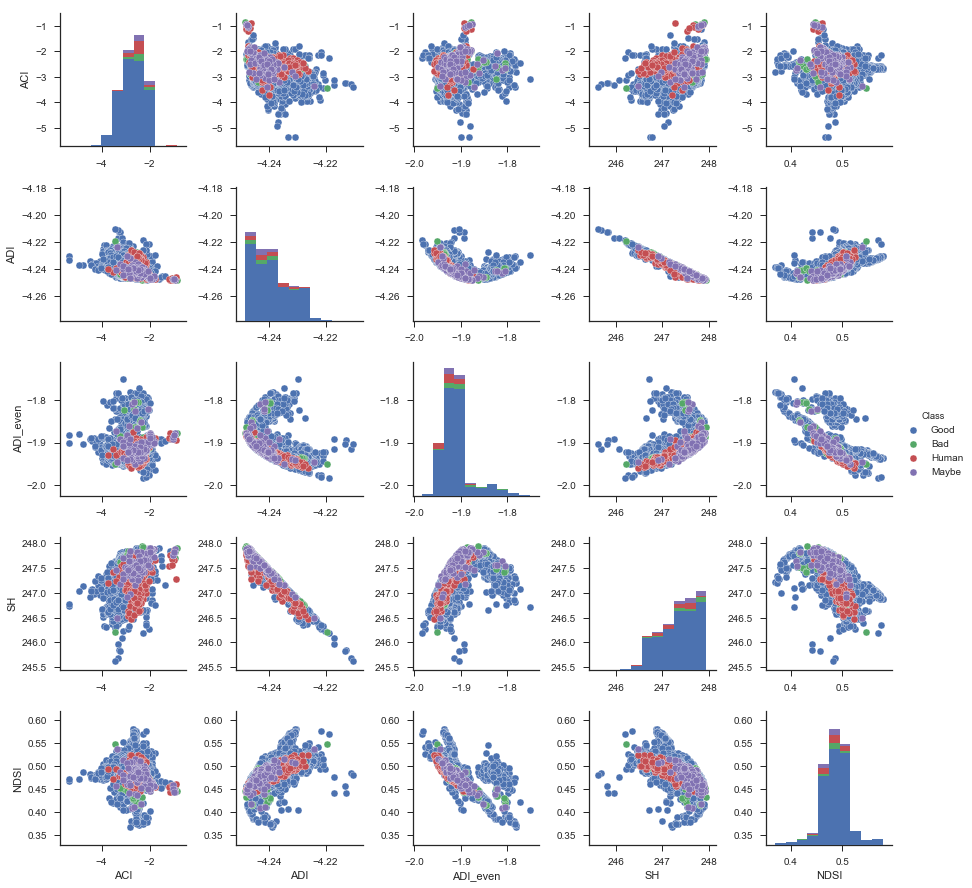

(3085, 6)


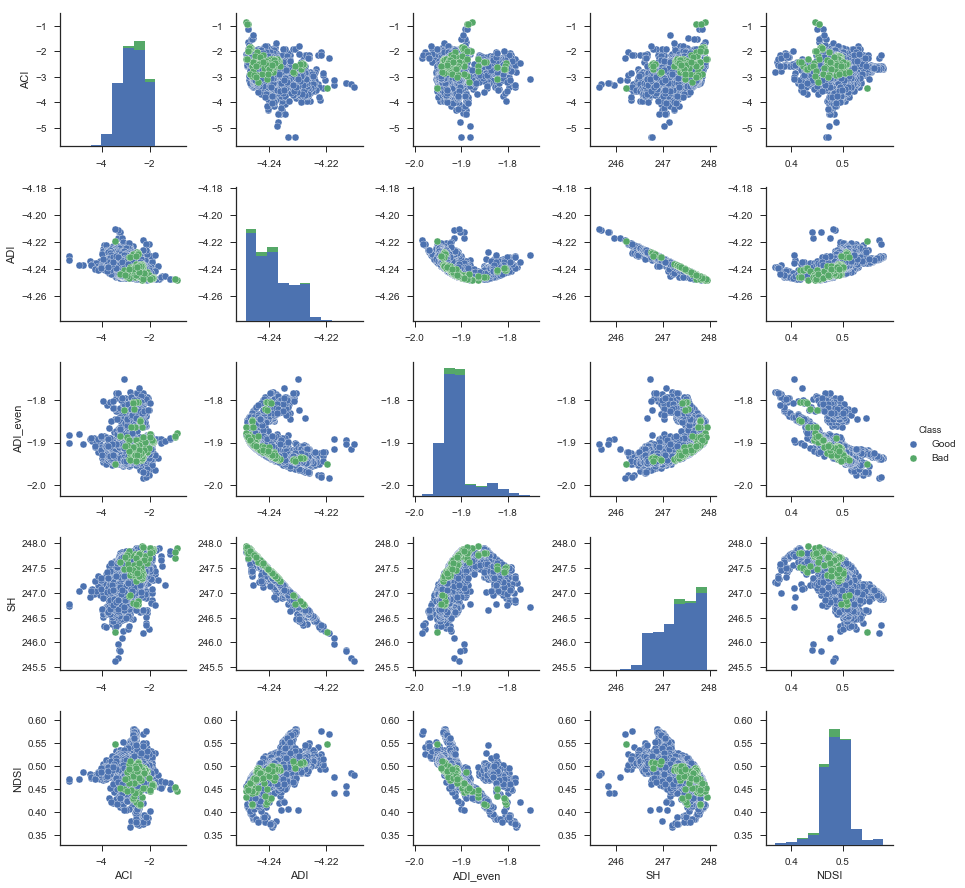

ACI       ADI  ADI_even          SH      NDSI Class
0 -2.140497 -4.239733 -1.925119  247.384476  0.501186  Good
1 -2.548170 -4.236537 -1.929581  247.235794  0.507842  Good
2 -3.035664 -4.235660 -1.912524  247.118698  0.478780  Good
3 -3.155140 -4.236479 -1.912569  247.098984  0.475351  Good
4 -2.402599 -4.237053 -1.927787  247.255890  0.495920  Good

In [19]:
all_data_df_orig, gb_data_df_orig = get_df_and_plot(-1, ACI_G, ADI_G, ADI_even_G, SH_G, NDSI_G, num_specs_g, ACI_B, ADI_B, ADI_even_B, SH_B, NDSI_B, num_specs_b, ACI_H, ADI_H, ADI_even_H, SH_H, NDSI_H, num_specs_h, ACI_M, ADI_M, ADI_even_M, SH_M, NDSI_M, num_specs_m)

all_data_df_orig.head()

(3421, 6)


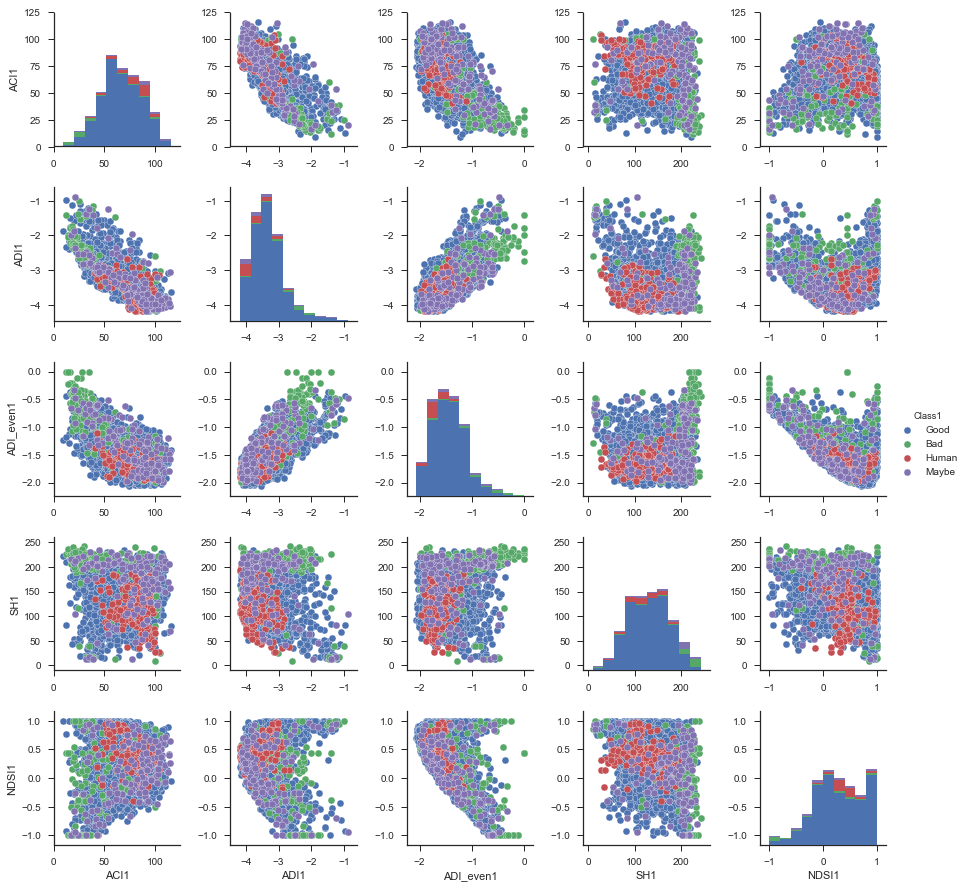

(3085, 6)


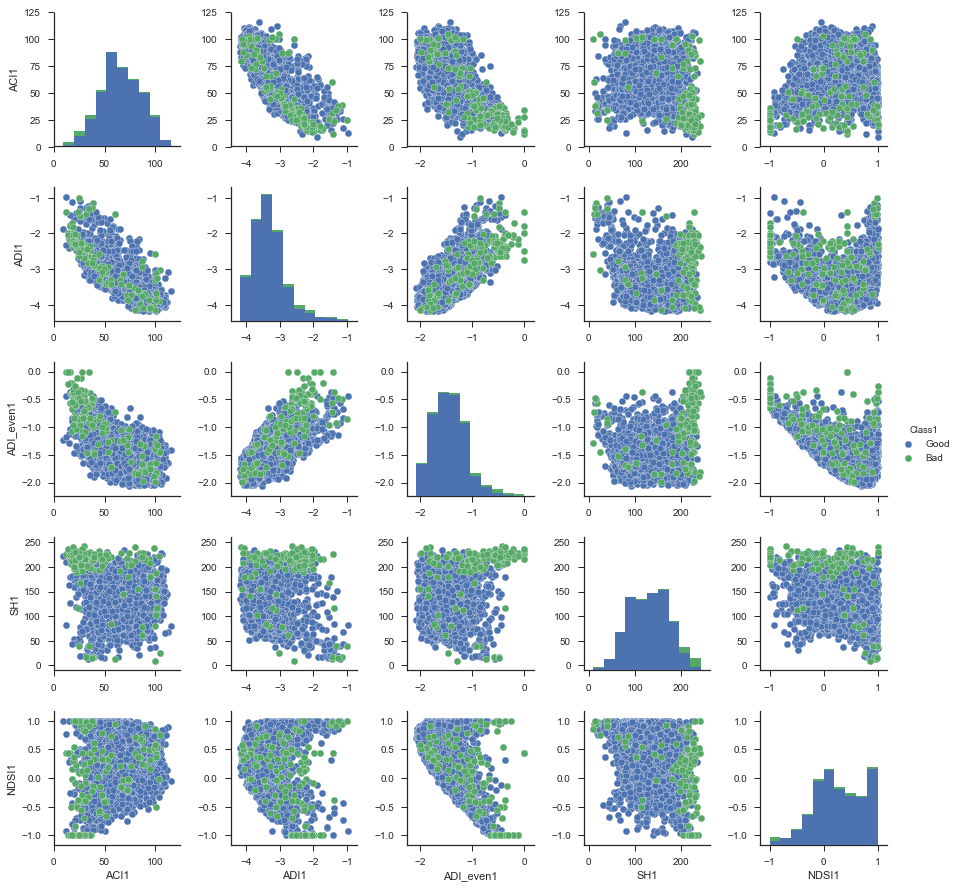

In [20]:
all_data_df1, gb_data_df1 = get_df_and_plot(1, ACI_G1, ADI_G1, ADI_even_G1, SH_G1, NDSI_G1, num_specs_g, ACI_B1, ADI_B1, ADI_even_B1, SH_B1, NDSI_B1, num_specs_b, ACI_H1, ADI_H1, ADI_even_H1, SH_H1, NDSI_H1, num_specs_h, ACI_M1, ADI_M1, ADI_even_M1, SH_M1, NDSI_M1, num_specs_m)


(3421, 6)


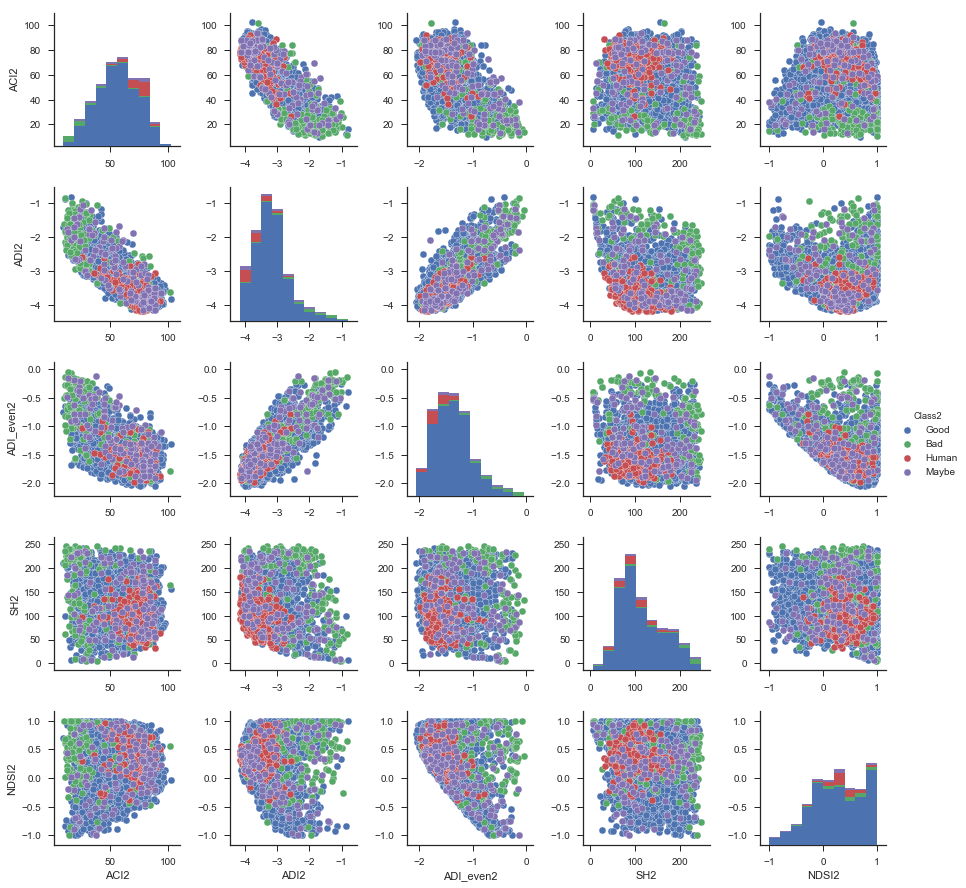

(3085, 6)


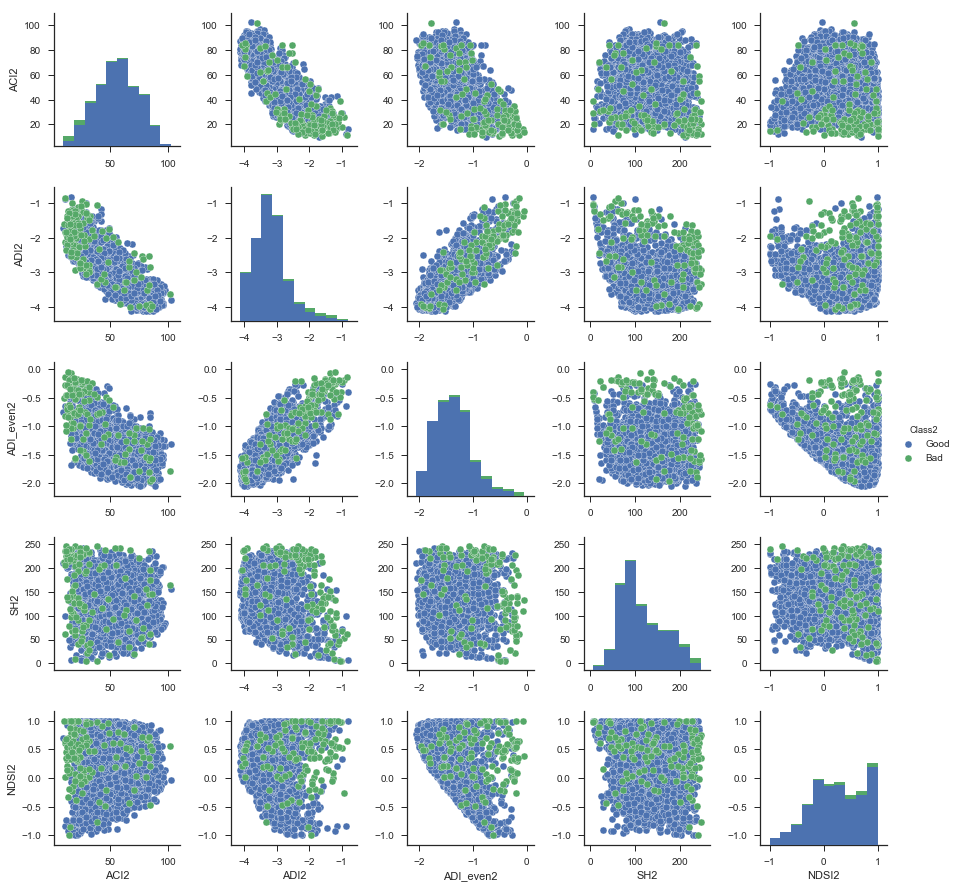

In [21]:
all_data_df2, gb_data_df2 = get_df_and_plot(2, ACI_G2, ADI_G2, ADI_even_G2, SH_G2, NDSI_G2, num_specs_g, ACI_B2, ADI_B2, ADI_even_B2, SH_B2, NDSI_B2, num_specs_b, ACI_H2, ADI_H2, ADI_even_H2, SH_H2, NDSI_H2, num_specs_h, ACI_M2, ADI_M2, ADI_even_M2, SH_M2, NDSI_M2, num_specs_m)


(3421, 6)


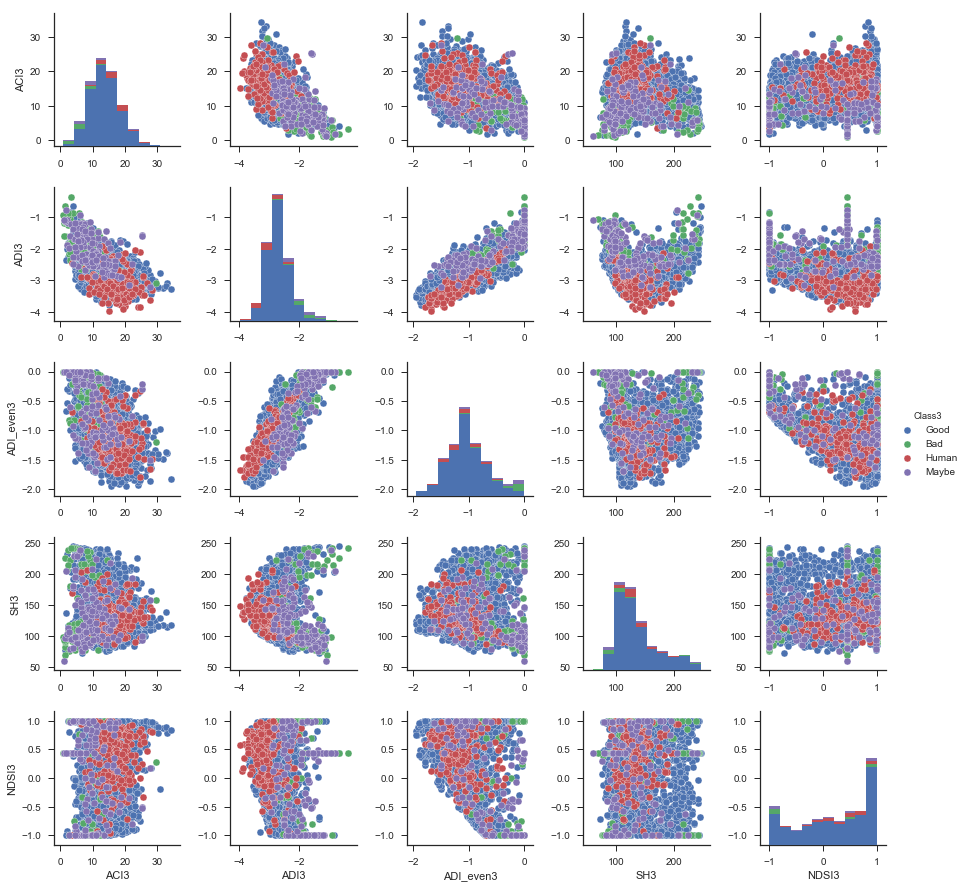

(3085, 6)


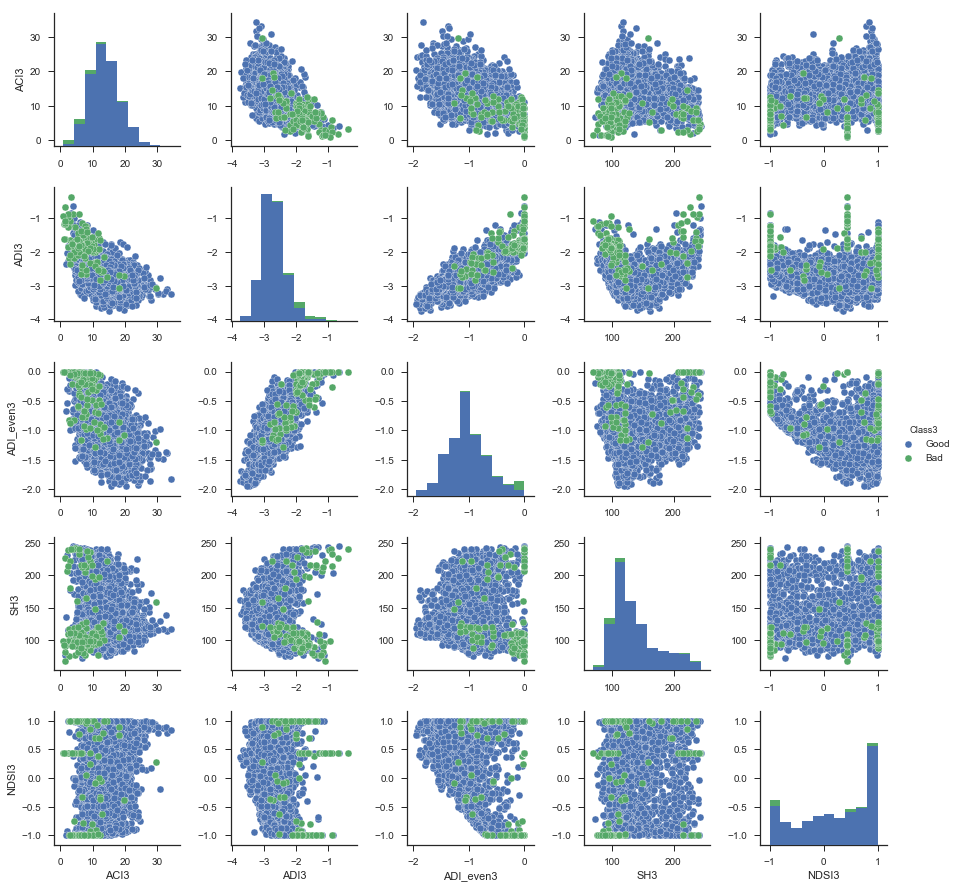

In [22]:
all_data_df3, gb_data_df3 = get_df_and_plot(3, ACI_G3, ADI_G3, ADI_even_G3, SH_G3, NDSI_G3, num_specs_g, ACI_B3, ADI_B3, ADI_even_B3, SH_B3, NDSI_B3, num_specs_b, ACI_H3, ADI_H3, ADI_even_H3, SH_H3, NDSI_H3, num_specs_h, ACI_M3, ADI_M3, ADI_even_M3, SH_M3, NDSI_M3, num_specs_m)

(3421, 6)


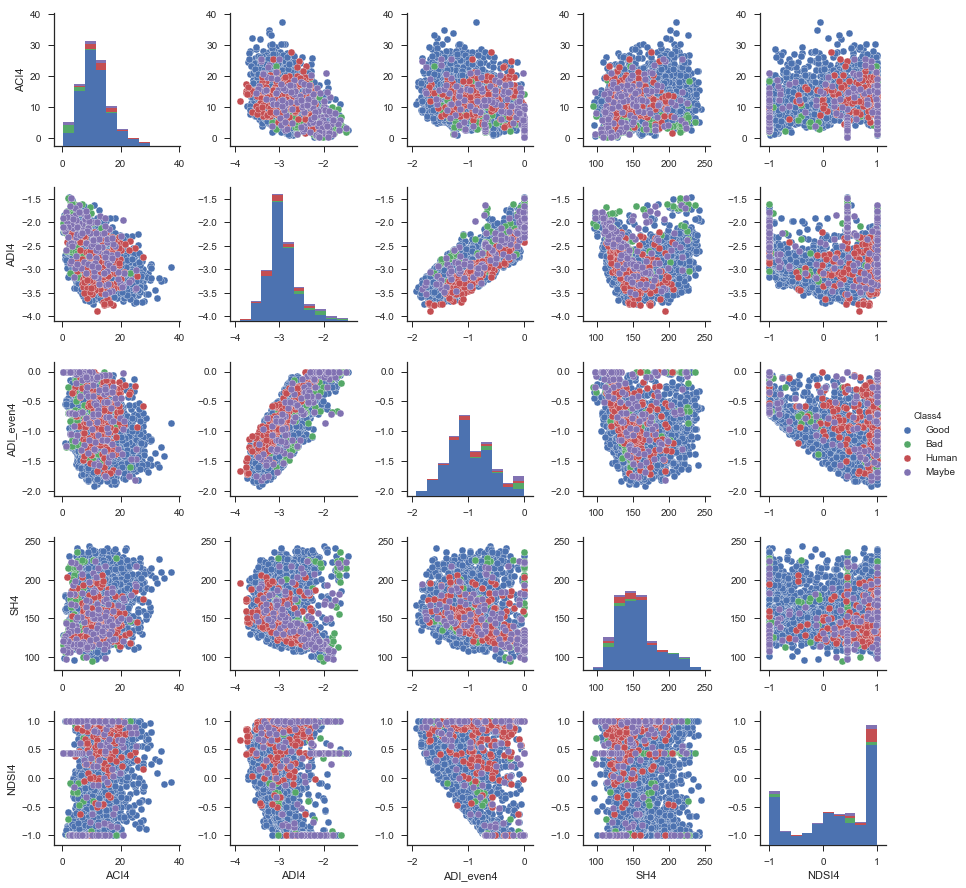

(3085, 6)


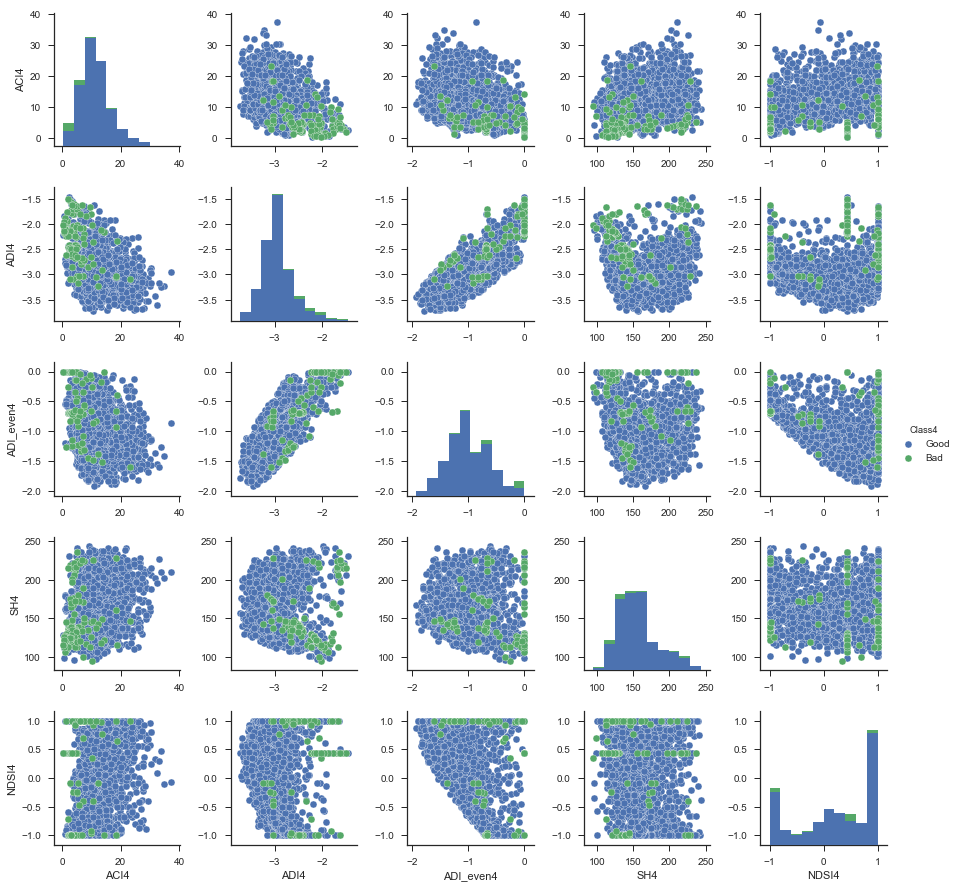

In [23]:
all_data_df4, gb_data_df4 = get_df_and_plot(4, ACI_G4, ADI_G4, ADI_even_G4, SH_G4, NDSI_G4, num_specs_g, ACI_B4, ADI_B4, ADI_even_B4, SH_B4, NDSI_B4, num_specs_b, ACI_H4, ADI_H4, ADI_even_H4, SH_H4, NDSI_H4, num_specs_h, ACI_M4, ADI_M4, ADI_even_M4, SH_M4, NDSI_M4, num_specs_m)


In [24]:
#Combining all 4 channels 
all_channel_arr = [all_data_df1, all_data_df2, all_data_df3, all_data_df4]
all_channel_df = pd.concat(all_channel_arr, axis=1)

print(all_channel_df.shape)
all_channel_df.head()


(3421, 24)


ACI1      ADI1  ADI_even1         SH1     NDSI1 Class1       ACI2  \
0  80.243286 -3.688047  -1.881208   88.359261  0.716630   Good  73.463295   
1  46.404182 -2.972167  -1.836112   93.825356  0.712668   Good  42.930161   
2  83.291245 -3.477021  -1.666841   92.698746  0.384758   Good  68.120468   
3  75.370430 -3.633843  -1.708756  102.503662  0.402326   Good  66.747864   
4  55.620201 -3.081301  -1.565449   89.164330  0.340162   Good  39.435158   

       ADI2  ADI_even2         SH2   ...    ADI_even3         SH3     NDSI3  \
0 -3.750207  -1.699613  117.615562   ...    -1.045067  119.389130 -0.220427   
1 -2.982163  -1.593020  112.048203   ...    -0.927017  125.993927 -0.586986   
2 -3.231578  -1.399250   84.859634   ...    -0.878492  133.952087  0.815964   
3 -3.226775  -1.552843  108.506966   ...    -1.047065  137.326294  0.751245   
4 -2.995456  -1.500386  103.042664   ...    -1.292281  128.013458  0.554435   

   Class3       ACI4      ADI4  ADI_even4         SH4     NDSI4  Class4  
0    Good   9.501211 -2.683312  -0.729801  131.340027 -0.872706    Good  
1    Good   7.652887 -3.027320  -0.829100  146.760773 -0.474450    Good  
2    Good  14.922321 -3.094808  -1.198582  149.502106  0.839093    Good  
3    Good  14.121132 -3.342966  -1.478061  148.837234  0.859028    Good  
4    Good   6.593496 -3.007673  -1.111393  126.410240  0.666144    Good  

[5 rows x 24 columns]

In [25]:
#doing the same for just good-bad data
good_bad_arr = [gb_data_df1, gb_data_df2, gb_data_df3, gb_data_df4]
good_bad_df = pd.concat(good_bad_arr, axis=1)

print(good_bad_df.shape)
good_bad_df.head()


(3085, 24)


ACI1      ADI1  ADI_even1         SH1     NDSI1 Class1       ACI2  \
0  80.243286 -3.688047  -1.881208   88.359261  0.716630   Good  73.463295   
1  46.404182 -2.972167  -1.836112   93.825356  0.712668   Good  42.930161   
2  83.291245 -3.477021  -1.666841   92.698746  0.384758   Good  68.120468   
3  75.370430 -3.633843  -1.708756  102.503662  0.402326   Good  66.747864   
4  55.620201 -3.081301  -1.565449   89.164330  0.340162   Good  39.435158   

       ADI2  ADI_even2         SH2   ...    ADI_even3         SH3     NDSI3  \
0 -3.750207  -1.699613  117.615562   ...    -1.045067  119.389130 -0.220427   
1 -2.982163  -1.593020  112.048203   ...    -0.927017  125.993927 -0.586986   
2 -3.231578  -1.399250   84.859634   ...    -0.878492  133.952087  0.815964   
3 -3.226775  -1.552843  108.506966   ...    -1.047065  137.326294  0.751245   
4 -2.995456  -1.500386  103.042664   ...    -1.292281  128.013458  0.554435   

   Class3       ACI4      ADI4  ADI_even4         SH4     NDSI4  Class4  
0    Good   9.501211 -2.683312  -0.729801  131.340027 -0.872706    Good  
1    Good   7.652887 -3.027320  -0.829100  146.760773 -0.474450    Good  
2    Good  14.922321 -3.094808  -1.198582  149.502106  0.839093    Good  
3    Good  14.121132 -3.342966  -1.478061  148.837234  0.859028    Good  
4    Good   6.593496 -3.007673  -1.111393  126.410240  0.666144    Good  

[5 rows x 24 columns]

In [26]:
#Max function
def get_max_ind(df):
    
    max_df = pd.DataFrame(columns=['ACI','ADI','ADI_even','SH','NDSI','Class'])
    max_df.head()
       
    max_df['ACI'] =       df[['ACI1','ACI2','ACI3','ACI4']].max(axis=1)    
    max_df['ADI'] =       df[['ADI1','ADI2','ADI3','ADI4']].max(axis=1)
    max_df['ADI_even'] =  df[['ADI_even1','ADI_even2','ADI_even3','ADI_even4']].max(axis=1)
    max_df['SH'] =        df[['SH1','SH2','SH3','SH4']].max(axis=1)
    max_df['NDSI'] =      df[['NDSI1','NDSI2','NDSI3','NDSI4']].max(axis=1)
    max_df['Class'] =     df['Class1']
    
    return max_df


In [27]:
#Average function
def get_avg_ind(df):
    
    avg_df = pd.DataFrame(columns=['ACI','ADI','ADI_even','SH','NDSI','Class'])
    avg_df.head()
    
    avg_df['ACI'] =      (df['ACI1']+df['ACI2']+df['ACI3']+df['ACI4'])/4
    avg_df['ADI'] =      (df['ADI1']+df['ADI2']+df['ADI3']+df['ADI4'])/4
    avg_df['ADI_even'] = (df['ADI_even1']+df['ADI_even2']+df['ADI_even3']+df['ADI_even4'])/4
    avg_df['SH'] =       (df['SH1']+df['SH2']+df['SH3']+df['SH4'])/4
    avg_df['NDSI'] =     (df['NDSI1']+df['NDSI2']+df['NDSI3']+df['NDSI4'])/4
    avg_df['Class'] =     df['Class1']
    
    return avg_df

(3421, 6)


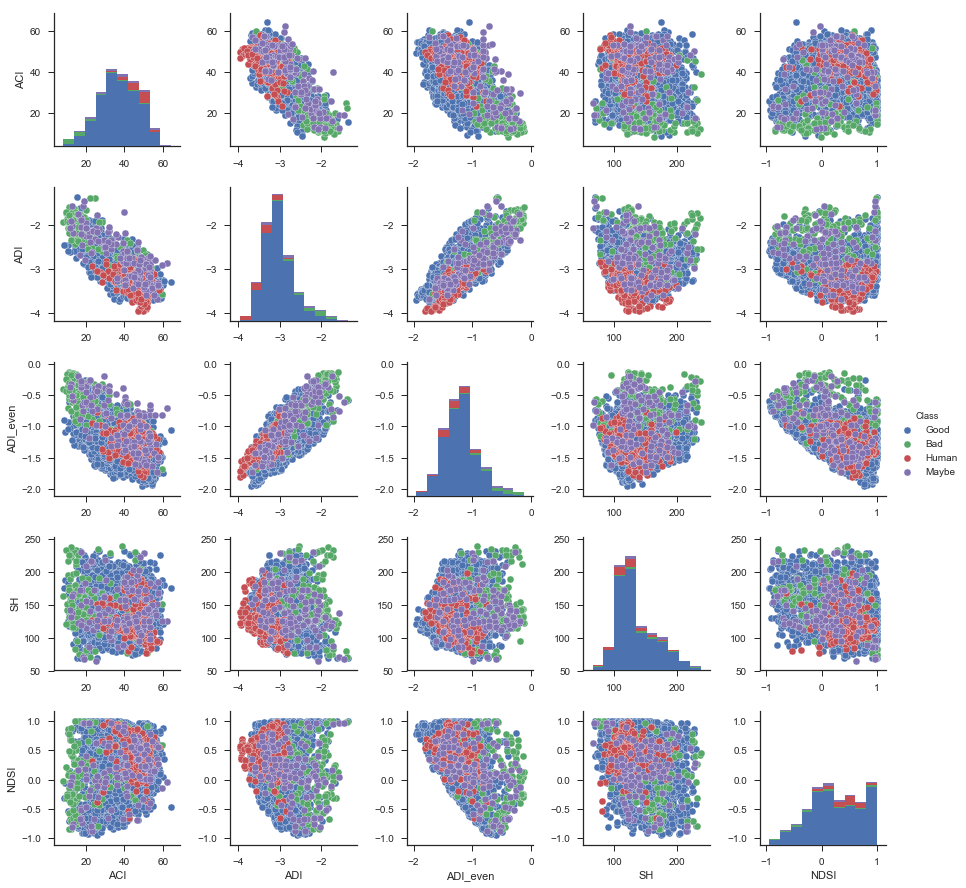

(3085, 6)


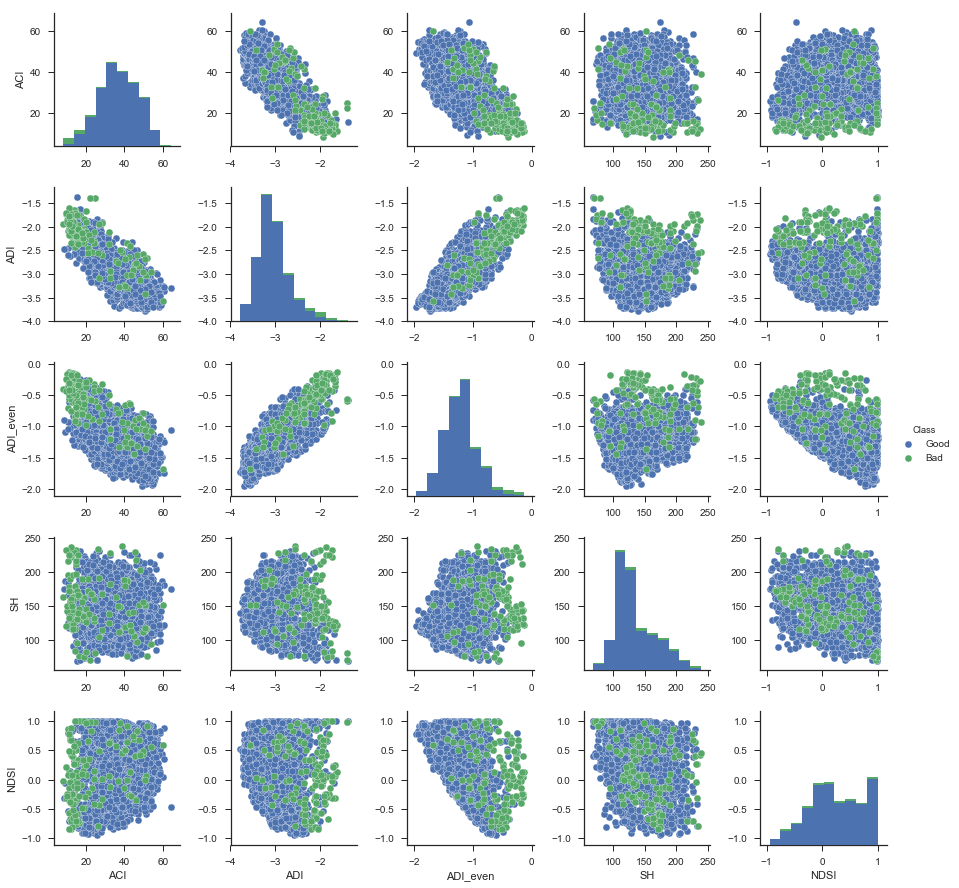

In [28]:
#Calling functions to combine the data - (1) Average (2) Max 

#Avg
avg_all_df = get_avg_ind(all_channel_df)
avg_gb_df = get_avg_ind(good_bad_df)

print(avg_all_df.shape)
sns.pairplot(avg_all_df, hue="Class")
plt.show()

print(avg_gb_df.shape)
sns.pairplot(avg_gb_df, hue="Class")
plt.show()

  

(3421, 6)


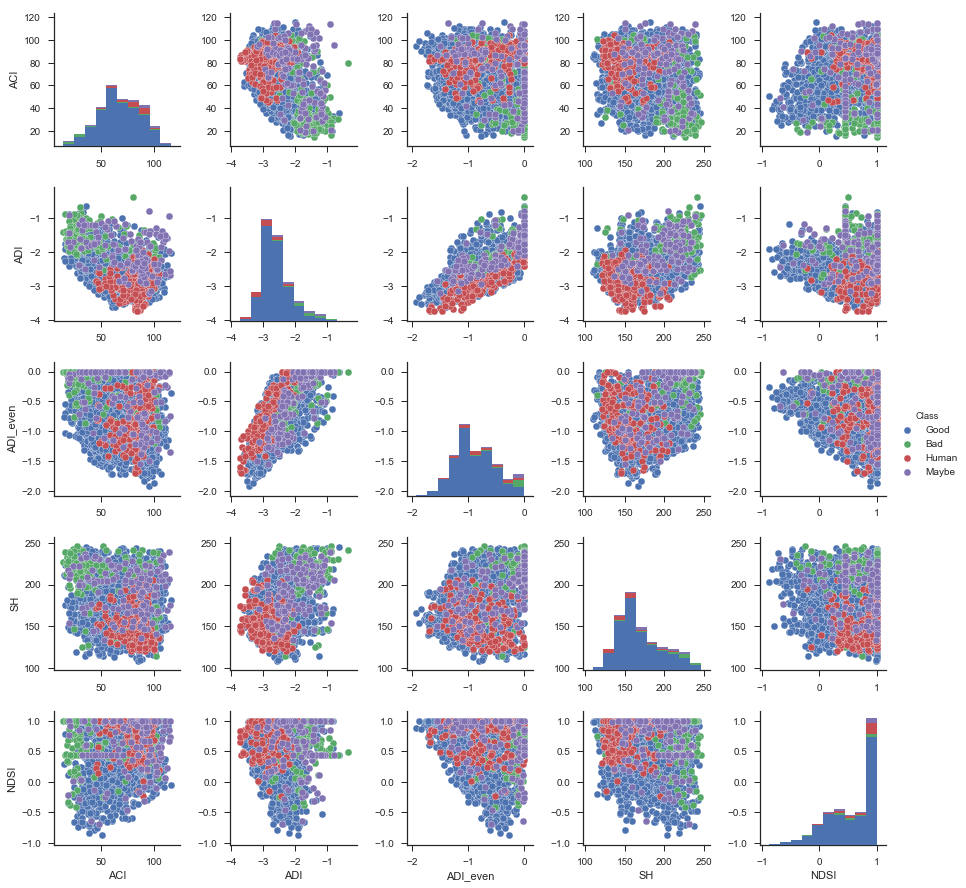

(3085, 6)


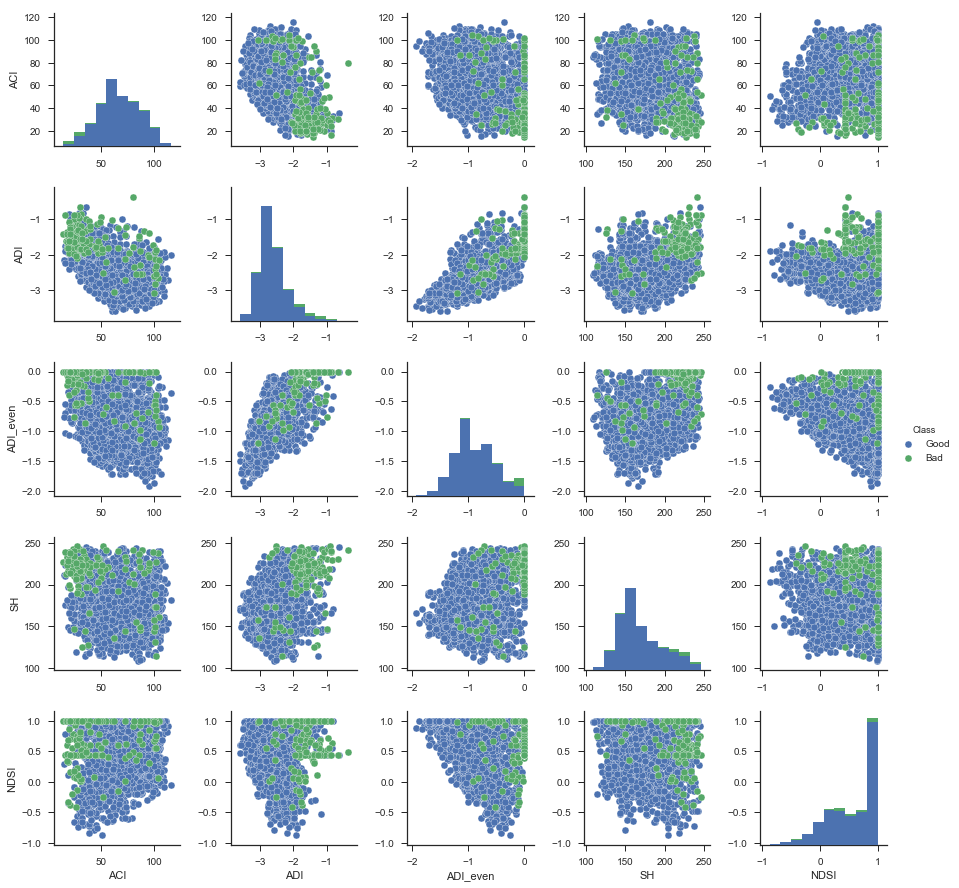

In [29]:
#Max
max_all_df = get_max_ind(all_channel_df)
max_gb_df = get_max_ind(good_bad_df)

print(max_all_df.shape)
sns.pairplot(max_all_df, hue="Class")
plt.show()

print(max_gb_df.shape)
sns.pairplot(max_gb_df, hue="Class")
plt.show()

In [30]:
#Note - dataframes here are - 
#Combined: (1) original - all_data_df_orig, gb_data_df_orig (2) channels - all_channel_df, good_bad_df
#Separate: channels - all_data_df1, gb_data_df2, etc.

In [31]:
def combine_specs_4_5(exp, spec_data, spec_start_idx, num_specs):
    
    if(exp==4):
        spec_1 = spec_data['specs'].max(axis=3, keepdims=False)
        
    elif(exp==5):
        spec_1 = spec_data['specs'].mean(axis=3, keepdims=False)

    #print(spec_1.shape)

    return spec_1
    

In [32]:
#calls all functions for each class - is for Exp4
def calls_exp_4_5(exp, class_name, spec_start_idx, num_specs, multiples, num_bins, dim, start_a_freq, stop_a_freq, start_b_freq, stop_b_freq, plot=0):

    #Load the correct file
    str_file = '_preprocessed_uncompressed.npz'
    spec_data, time_steps, freq_bins = load_display_dimensions(class_name, str_file, dim)
    
    #Calling helper function for compute_adi_even
    start_freq_idx, stop_freq_idx = get_start_stop_indices(spec_data['spec_f'], multiples, num_bins)

    #Combining spectrograms
    new_spec = combine_specs_4_5(exp, spec_data, spec_start_idx, num_specs)
    
    #Computing acoustic indices for all 4 channels
    ch = 5
    print(new_spec.shape)
    
    ACI, ADI, ADI_even, SH, NDSI = calc_plot(num_bins, spec_start_idx, num_specs, new_spec, ch, time_steps, freq_bins, spec_data['spec_f'], start_freq_idx, stop_freq_idx, start_a_freq, stop_a_freq, start_b_freq, stop_b_freq, plot)
    
    return ACI, ADI, ADI_even, SH, NDSI

In [33]:
#Calls for each class - Exp 4 with max values

exp = 4
ACI_G_exp4, ADI_G_exp4, ADI_even_G_exp4, SH_G_exp4, NDSI_G_exp4 = calls_exp_4_5(exp, class1, spec_start_idx, num_specs_g, multiples, num_bins, dim, start_a_freq, stop_a_freq, start_b_freq, stop_b_freq, plot)
print("Done with class Good")

ACI_B_exp4, ADI_B_exp4, ADI_even_B_exp4, SH_B_exp4, NDSI_B_exp4 = calls_exp_4_5(exp, class2, spec_start_idx, num_specs_b, multiples, num_bins, dim, start_a_freq, stop_a_freq, start_b_freq, stop_b_freq, plot)
print("Done with class Bad")

ACI_H_exp4, ADI_H_exp4, ADI_even_H_exp4, SH_H_exp4, NDSI_H_exp4 = calls_exp_4_5(exp, class3, spec_start_idx, num_specs_h, multiples, num_bins, dim, start_a_freq, stop_a_freq, start_b_freq, stop_b_freq, plot)
print("Done with class Human")

ACI_M_exp4, ADI_M_exp4, ADI_even_M_exp4, SH_M_exp4, NDSI_M_exp4 = calls_exp_4_5(exp, class4, spec_start_idx, num_specs_m, multiples, num_bins, dim, start_a_freq, stop_a_freq, start_b_freq, stop_b_freq, plot)
print("Done with class Maybe")



File has 2958 specs of dimensions (70 x 248)
Frequency axis points are in spec_data['spec_f'] and has 70 values
Time axis points are in spec_data['spec_t'] and has 248 values
(2958, 70, 248)
Done with class Good
File has 127 specs of dimensions (70 x 248)
Frequency axis points are in spec_data['spec_f'] and has 70 values
Time axis points are in spec_data['spec_t'] and has 248 values
(127, 70, 248)
Done with class Bad
File has 205 specs of dimensions (70 x 248)
Frequency axis points are in spec_data['spec_f'] and has 70 values
Time axis points are in spec_data['spec_t'] and has 248 values
(205, 70, 248)
Done with class Human
File has 131 specs of dimensions (70 x 248)
Frequency axis points are in spec_data['spec_f'] and has 70 values
Time axis points are in spec_data['spec_t'] and has 248 values
(131, 70, 248)
Done with class Maybe


(3421, 6)


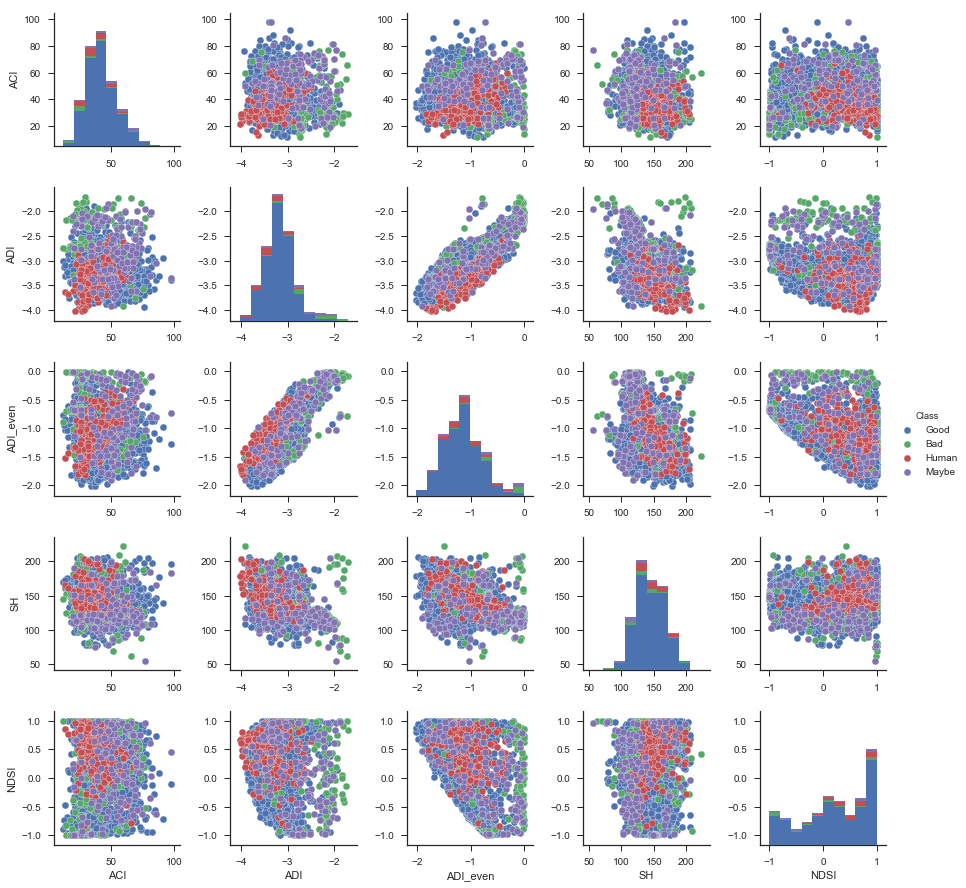

(3085, 6)


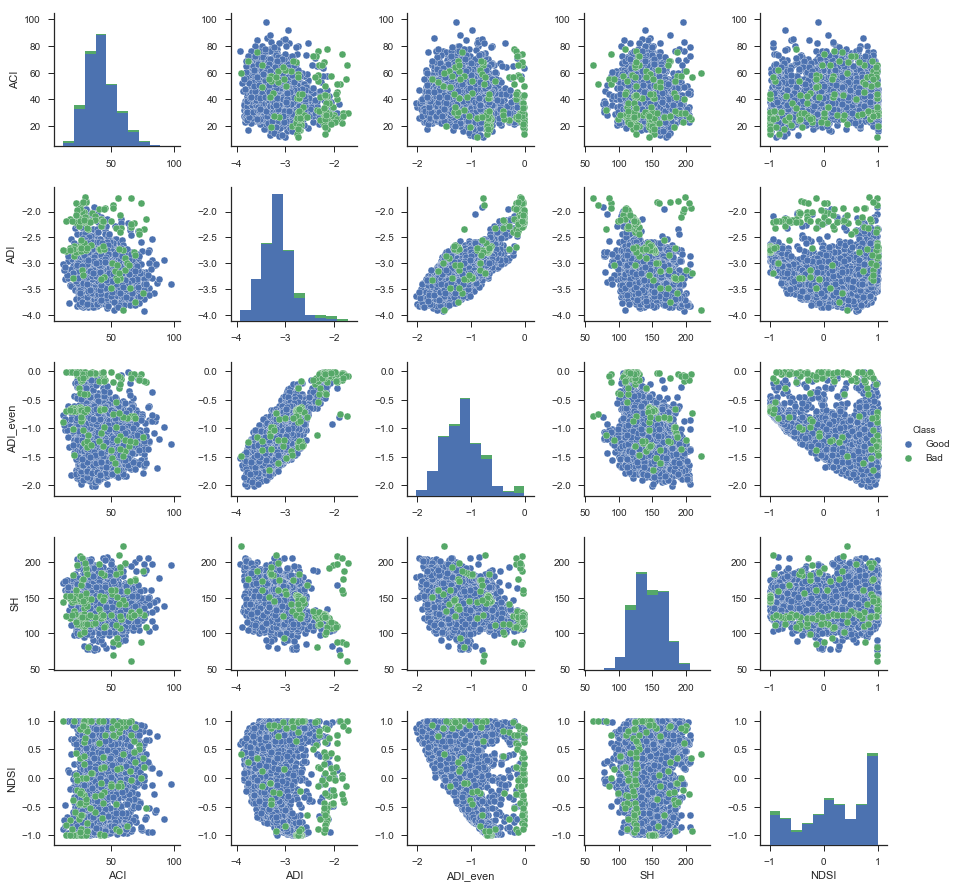

ACI       ADI  ADI_even          SH      NDSI Class
0  47.336346 -3.307718 -1.253507  121.789436 -0.350057  Good
1  34.411781 -3.418361 -1.116988  117.132637 -0.364263  Good
2  39.277775 -3.437433 -1.338696  155.746185  0.788723  Good
3  34.105923 -3.633024 -1.594103  161.160400  0.772376  Good
4  29.999531 -3.381933 -1.369141  135.858109  0.539519  Good

In [34]:
#Plotting for Exp4
all_data_df_exp4, gb_data_df_exp4 = get_df_and_plot(5, ACI_G_exp4, ADI_G_exp4, ADI_even_G_exp4, SH_G_exp4, NDSI_G_exp4, num_specs_g, ACI_B_exp4, ADI_B_exp4, ADI_even_B_exp4, SH_B_exp4, NDSI_B_exp4, num_specs_b, ACI_H_exp4, ADI_H_exp4, ADI_even_H_exp4, SH_H_exp4, NDSI_H_exp4, num_specs_h, ACI_M_exp4, ADI_M_exp4, ADI_even_M_exp4, SH_M_exp4, NDSI_M_exp4, num_specs_m)

all_data_df_exp4.head()

In [35]:
#Calls for each class - Exp 5 with  avg values

exp = 5
ACI_G_exp5, ADI_G_exp5, ADI_even_G_exp5, SH_G_exp5, NDSI_G_exp5 = calls_exp_4_5(exp, class1, spec_start_idx, num_specs_g, multiples, num_bins, dim, start_a_freq, stop_a_freq, start_b_freq, stop_b_freq, plot)
print("Done with class Good")

ACI_B_exp5, ADI_B_exp5, ADI_even_B_exp5, SH_B_exp5, NDSI_B_exp5 = calls_exp_4_5(exp, class2, spec_start_idx, num_specs_b, multiples, num_bins, dim, start_a_freq, stop_a_freq, start_b_freq, stop_b_freq, plot)
print("Done with class Bad")

ACI_H_exp5, ADI_H_exp5, ADI_even_H_exp5, SH_H_exp5, NDSI_H_exp5 = calls_exp_4_5(exp, class3, spec_start_idx, num_specs_h, multiples, num_bins, dim, start_a_freq, stop_a_freq, start_b_freq, stop_b_freq, plot)
print("Done with class Human")

ACI_M_exp5, ADI_M_exp5, ADI_even_M_exp5, SH_M_exp5, NDSI_M_exp5 = calls_exp_4_5(exp, class4, spec_start_idx, num_specs_m, multiples, num_bins, dim, start_a_freq, stop_a_freq, start_b_freq, stop_b_freq, plot)
print("Done with class Maybe")

File has 2958 specs of dimensions (70 x 248)
Frequency axis points are in spec_data['spec_f'] and has 70 values
Time axis points are in spec_data['spec_t'] and has 248 values
(2958, 70, 248)
Done with class Good
File has 127 specs of dimensions (70 x 248)
Frequency axis points are in spec_data['spec_f'] and has 70 values
Time axis points are in spec_data['spec_t'] and has 248 values
(127, 70, 248)
Done with class Bad
File has 205 specs of dimensions (70 x 248)
Frequency axis points are in spec_data['spec_f'] and has 70 values
Time axis points are in spec_data['spec_t'] and has 248 values
(205, 70, 248)
Done with class Human
File has 131 specs of dimensions (70 x 248)
Frequency axis points are in spec_data['spec_f'] and has 70 values
Time axis points are in spec_data['spec_t'] and has 248 values
(131, 70, 248)
Done with class Maybe


(3421, 6)


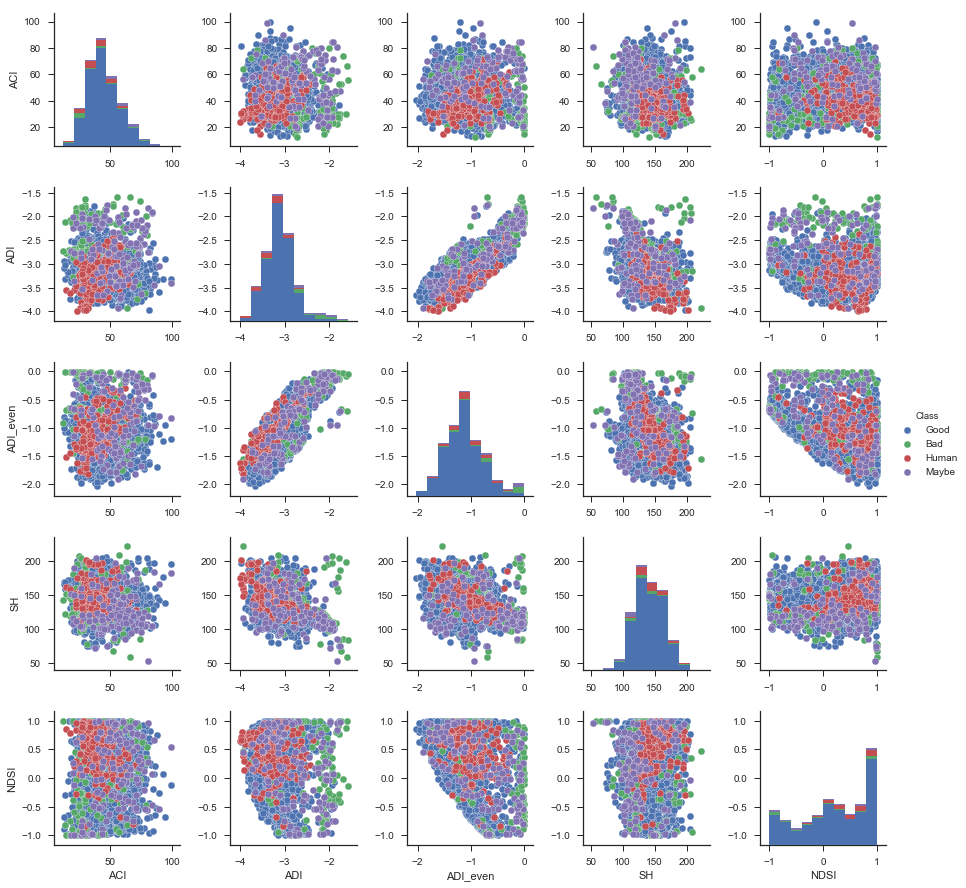

(3085, 6)


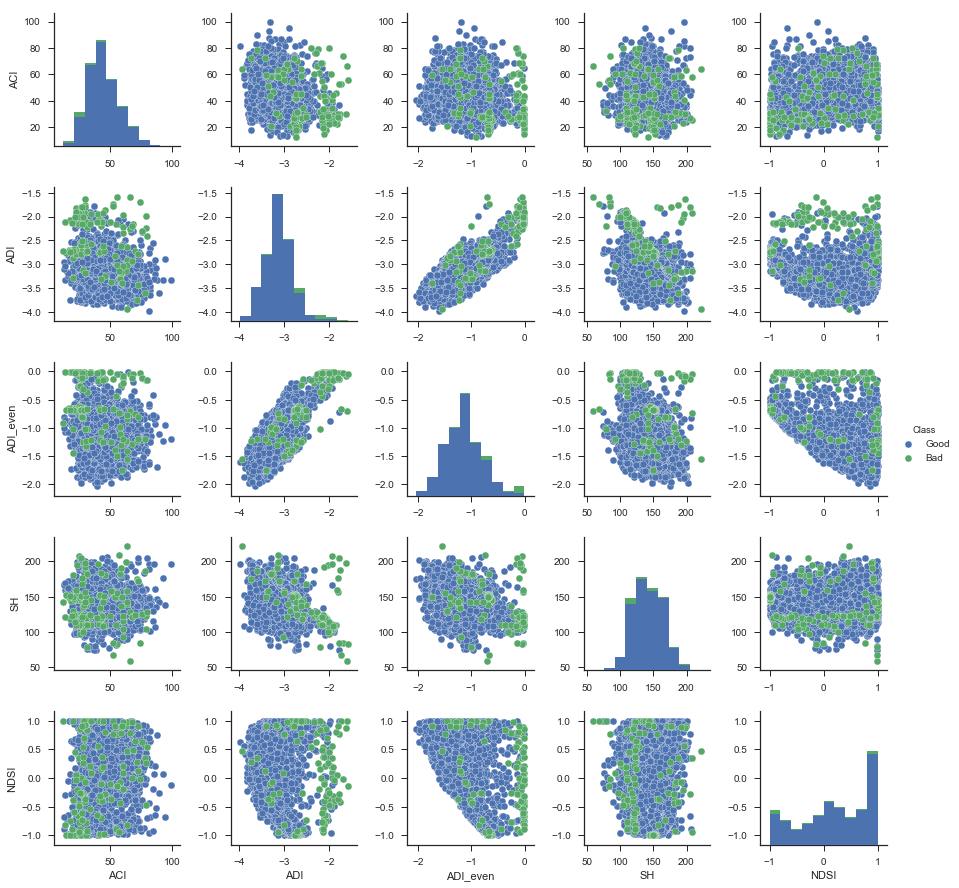

ACI       ADI  ADI_even          SH      NDSI Class
0  50.755032 -3.199665 -1.144119  119.583839 -0.452718  Good
1  35.720200 -3.338274 -1.058135  114.935837 -0.408966  Good
2  42.735149 -3.328904 -1.225720  151.997910  0.789099  Good
3  36.873341 -3.502190 -1.458294  157.562027  0.777032  Good
4  31.142067 -3.300461 -1.300855  133.043182  0.590304  Good

In [36]:
#Plotting for Exp5
all_data_df_exp5, gb_data_df_exp5 = get_df_and_plot(5, ACI_G_exp5, ADI_G_exp5, ADI_even_G_exp5, SH_G_exp5, NDSI_G_exp5, num_specs_g, ACI_B_exp5, ADI_B_exp5, ADI_even_B_exp5, SH_B_exp5, NDSI_B_exp5, num_specs_b, ACI_H_exp5, ADI_H_exp5, ADI_even_H_exp5, SH_H_exp5, NDSI_H_exp5, num_specs_h, ACI_M_exp5, ADI_M_exp5, ADI_even_M_exp5, SH_M_exp5, NDSI_M_exp5, num_specs_m)

all_data_df_exp5.head()